### Prediction Pipeline

Useful information for running the prediction pipeline and checking the outputs of various stages.

**Kernel**

All relevant software should be found in the lsd_new conda environment.

This Jupyter notebooks should use the lsd_new Python kernel in VS Code:

Select Kernel > lsd_new (Python 3.10.12)


**Note: Monitoring System Activity**

Different instances are optimized for different stages of the pipeline. The first stage will require the GPU instance AWS_LSD_g5.2xlarge

Subsequent stages do not require a GPU, and need more CPUs and RAM. For example, the AWS_LSD_m5a.8xlarge instance is a good general use machine with a balance between CPUs and RAM (32 vCPU, 128 GB RAM, no VRAM).

The performance of an instance can be monitored using the Netdata web dashboard. You can gain access using VS Code's port forwarding. Go into the Ports tab in VS Code, typically next to the Terminal tab in the output panel at the bottom of the screen. The NetData Port is 19999, which can be opened by hovering over the forwarded address, "localhost:19999" then selecting 'Open in Browser' with the the globe icon.


#### Step 1: Predict Affinities

Training and the first stage of the prediction pipeline must be performed on an instance with a GPU, such as the g5.2xlarge 

It's generally best to set up a screen so that your commands will continue to run in the background if you disconnect, or close the terminal window. 

Run the prediction script:

```
screen -S predict
conda activate lsd_new
cd /data/base/3M-APP-SCN/02_train/mtlsd_soma
python predict_blockwise.py 01_predict_blockwise.json
```

This took about 45 minutes for the (200, 2000, 2000) data volume. The output zarr with the pred_affs and pred_lsds datasets should be in /data/base/3M-APP-SCN/02_train/setup04/prediction/CompImBio800M-Soma.zarr

Downstream steps in the pipeline do not require a GPU, but require more parallel CPU workers and significant amounts of RAM so should be performed on the other instance types such as LSD_m5a.8xlarge. The amount of workers may need to be adjusted to prevent out of memory errors, as well as to make full usage of the available resources. 


In [2]:
import zarr 
import numpy as np 
import os
import matplotlib.pyplot as plt
import hashlib
import time

def create_lut(labels):
    print("create_lut")
    start = time.time()
    labels = labels.astype(np.int64)  # ensure labels are integer
    max_label = np.max(labels)
    lut = np.zeros((int(max_label + 1), 4), dtype=np.uint8)
    lut[:, 3] = 255  # alpha channel
    for label in range(1, int(max_label + 1)):
        # Generate a deterministic RGB color based on label
        print(f"Processing {label}", end="\r")
        md5 = hashlib.md5()
        md5.update(str(label).encode('utf-8'))
        color_hash = md5.hexdigest()
        lut[label, :3] = [int(color_hash[i:i+2], 16) for i in (0, 2, 4)]
    colored_labels = lut[labels]
    end = time.time()
    print(f"\nTime elapsed: {round(end-start,3)}s")
    return colored_labels

# Optimized version
def create_lut_optimized(labels):
    print(f"create_lut_optimized")
    start = time.time()
    unique_labels = np.unique(labels)
    unique_labels = np.setdiff1d(unique_labels, [0])  # Efficiently remove 0
    max_label = unique_labels.max()

    # Dictionary to store color for each label
    color_dict = {}

    # Initialize LUT with zeros
    lut = np.zeros((int(max_label + 1), 4), dtype=np.uint8)
    lut[:, 3] = 255  # alpha channel

    num_unique = len(unique_labels)
    print(f"Number of unique labels: {num_unique}")

    for i, label in enumerate(unique_labels):
        print(f"Processing {i}/{num_unique} {round(((i+1)/num_unique)*100.0)}%", end='\r')
        if label not in color_dict:
            # Generate a deterministic RGB color based on label
            md5 = hashlib.md5()
            md5.update(str(label).encode('utf-8'))
            color_hash = md5.hexdigest()
            color = [int(color_hash[i:i+2], 16) for i in (0, 2, 4)]
            color_dict[label] = color
        
        lut[label, :3] = color_dict[label]

    colored_labels = lut[labels]

    end = time.time()
    print(f"\nTime elapsed: {round(end-start,3)}s")

    return colored_labels

In [3]:
layer = 50

data = zarr.open('/data/base/3M-APP-SCN/01_data/CompImBio800M.zarr', mode='r')
preds = zarr.open('/data/base/3M-APP-SCN/02_train/mtlsd_soma/prediction/CompImBio800M-Soma.zarr', mode='r')
# preds_400 = zarr.open('/data/base/3M-APP-SCN/02_train/mtlsd_soma/prediction/APP-3M-SCN-SomaGT_400k.zarr', mode='r')


In [3]:
print(data['raw'][50].shape)
data['raw'][50]

(2000, 2000)


array([[180, 183, 163, ..., 173, 185, 182],
       [181, 164, 169, ..., 184, 196, 186],
       [185, 186, 152, ..., 174, 186, 187],
       ...,
       [181, 176, 183, ..., 185, 187, 177],
       [179, 175, 177, ..., 175, 187, 177],
       [168, 177, 158, ..., 177, 170, 184]], dtype=uint8)

In [10]:
list(data['/'].array_keys())

['labels', 'raw']

create_lut
Processing 340
Time elapsed: 0.096s


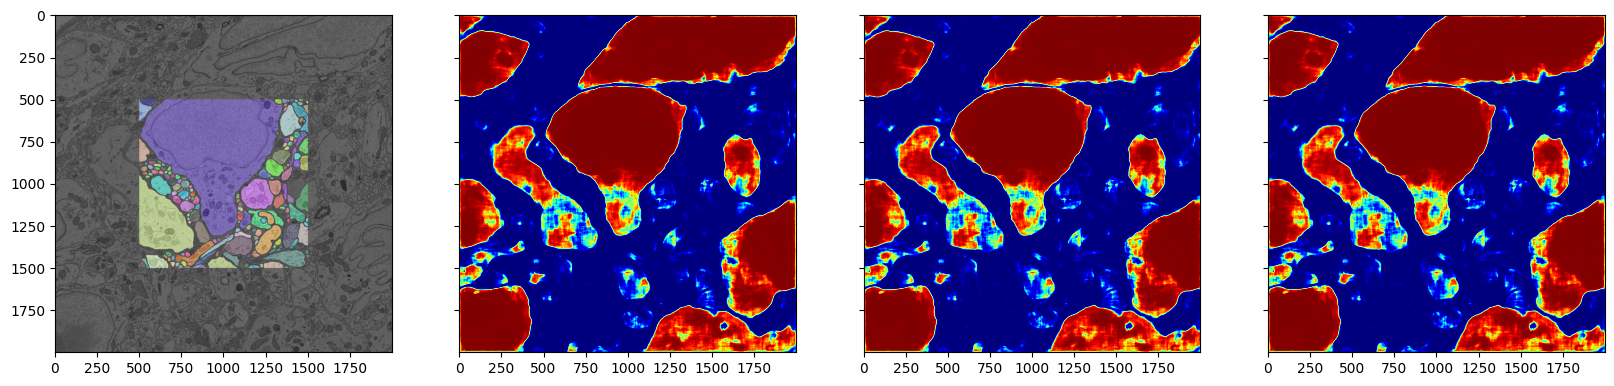

In [13]:
def display_preds_layer(layer, data, preds):
    # layer = 100
    raw_layer = data['raw'][layer,:,:]
    soma_layer = data['labels'][layer,:,:]
    pred_affs_layer = preds['pred_affs'][:,layer,:,:] # 4D tensor

    # The LSD model predicts affinities in the Z,Y,X dimensions. 
    # High values indicate that the given voxel is likely to be part of the same 
    #  object as the neighboring voxel  
    

    fig, axes = plt.subplots(
                1,
                4,
                figsize=(20, 6),
                sharex=True,
                sharey=True,
                squeeze=False)

    # view predictions (for lsds we will just view the mean offset component)
    axes[0][0].imshow(raw_layer, cmap='gray')
    axes[0][0].imshow(create_lut(np.array(soma_layer)), alpha=0.5)
    # axes[0][0].imshow(np.squeeze(pred_affs_layer[0]), cmap='jet', alpha=0.3)
    axes[0][1].imshow(np.squeeze(pred_affs_layer[0]), cmap='jet')
    axes[0][2].imshow(np.squeeze(pred_affs_layer[1]), cmap='jet')
    axes[0][3].imshow(np.squeeze(pred_affs_layer[2]), cmap='jet')

    # axes[0][0].imshow(create_lut(np.squeeze(segmentation)), alpha=0.7)

display_preds_layer(100, data, preds)

create_lut
Processing 342
Time elapsed: 0.096s


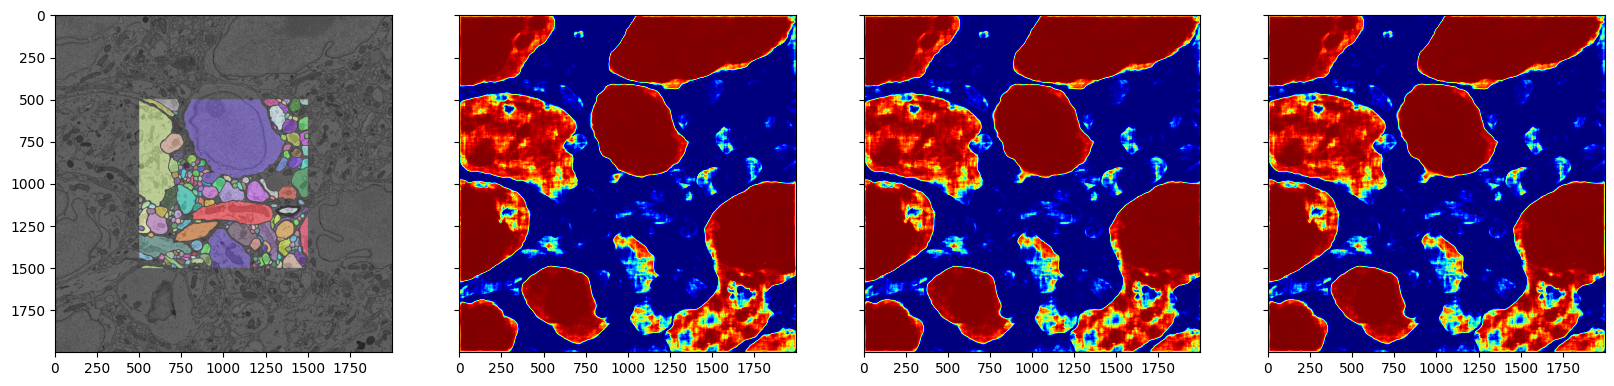

In [14]:
display_preds_layer(50, data, preds)

create_lut

Time elapsed: 0.093s


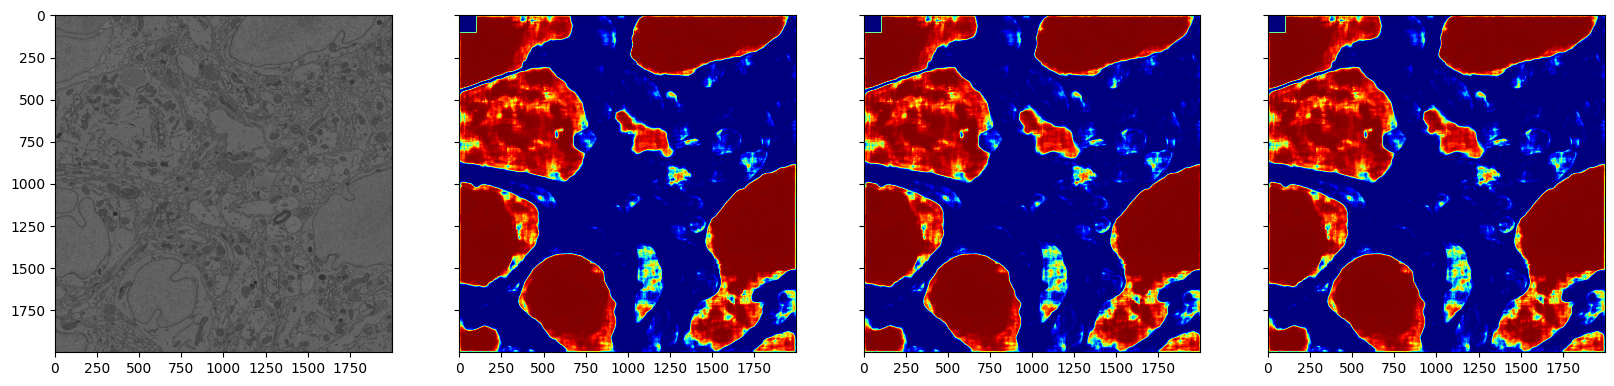

In [15]:
display_preds_layer(25, data, preds)

### Step 2: Extract Fragments

Update the 02_extract_fragments.json file as needed. We are using a mask file so that we do not predict for neurites where we know there are large bodies from the ground truth data. If you want to try to predict the entire volume with no mask then that field can be None.

Run the extract fragments script:

```
python extract_fragments_mongo.py 02_extract_fragments.json
```

Review the fragments file:

In [16]:
len(np.unique(preds['fragments'][50]))

953

create_lut_optimized
Number of unique labels: 952
Processing 951/952 100%
Time elapsed: 10.599s


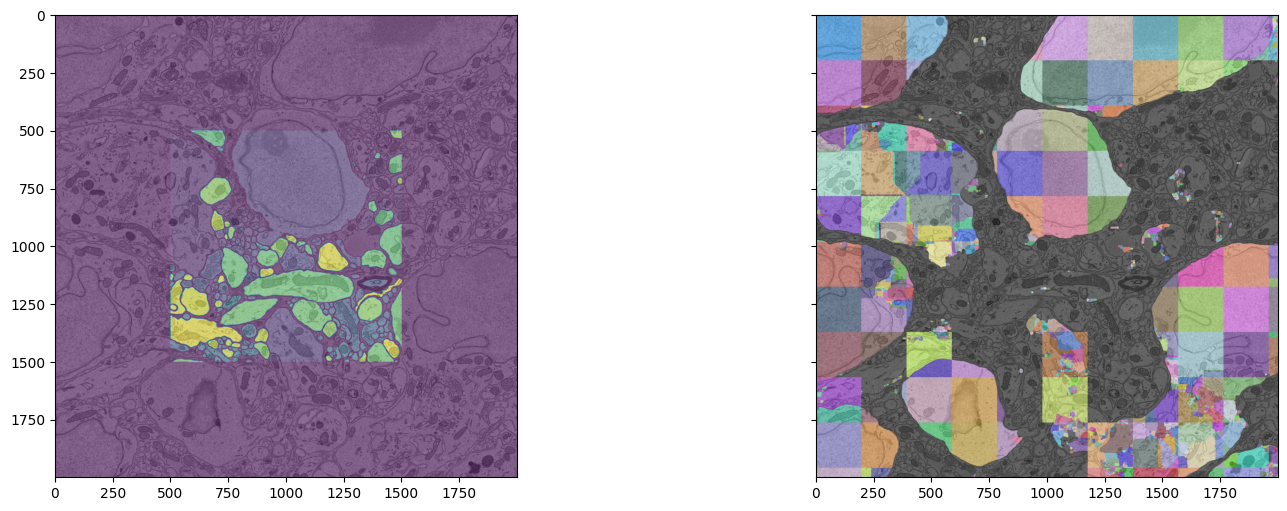

In [19]:
layer = 50
raw_layer = data['raw'][layer,:,:]
labels_layer = data['labels'][layer,:,:]
# soma_layer = create_lut(np.squeeze(data['soma'][layer,:,:]))
# soma_mask_layer = create_lut_optimized(np.squeeze(data['soma_mask'][layer,:,:]))
fragments_layer = create_lut_optimized(np.squeeze(preds['fragments'][layer,:,:]))

fig, axes = plt.subplots(
            1,
            2,
            figsize=(18, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

# view predictions (for lsds we will just view the mean offset component)
axes[0][0].imshow(raw_layer, cmap='gray')
axes[0][0].imshow(labels_layer, alpha=0.5)
axes[0][1].imshow(raw_layer, cmap='gray')
axes[0][1].imshow(fragments_layer, alpha=0.5)


create_lut_optimized
Number of unique labels: 952
Processing 951/952 100%
Time elapsed: 10.59s


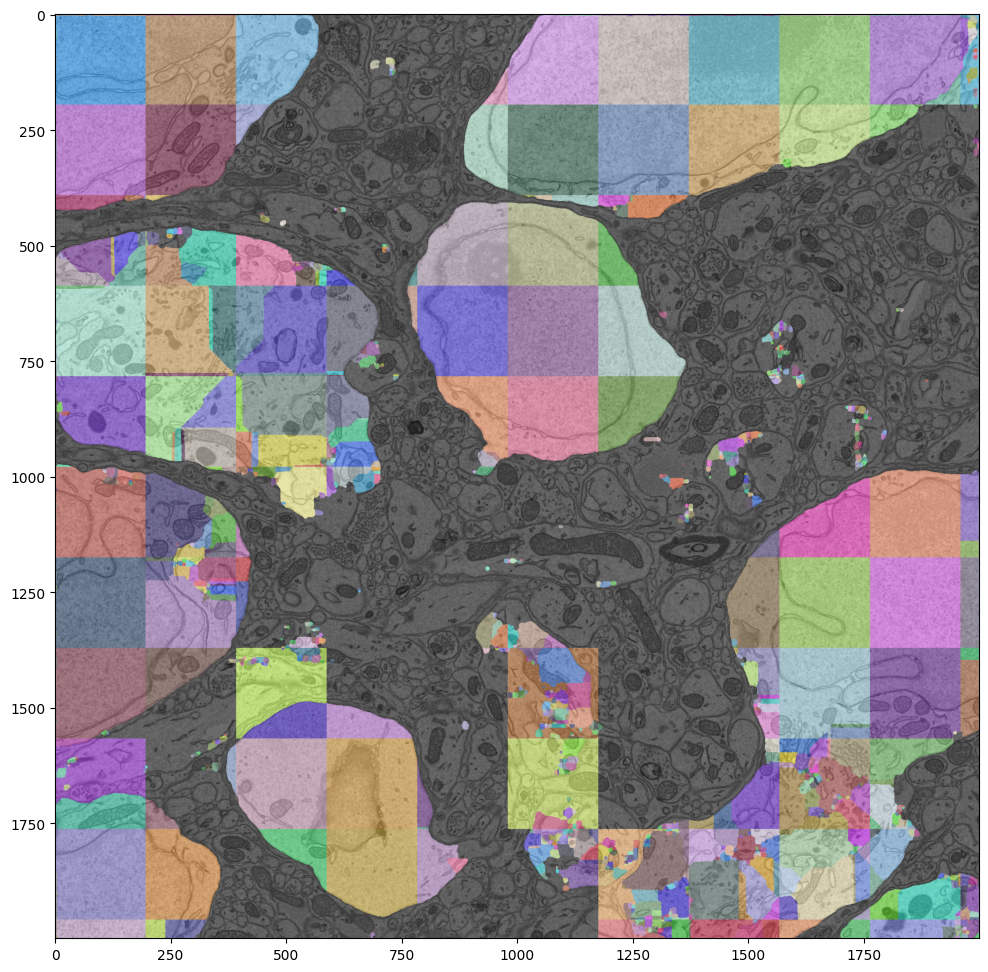

In [20]:
layer = 50
raw_layer = data['raw'][layer,:,:]
# soma_layer = create_lut(np.squeeze(data['soma'][layer,:,:]))
# soma_mask_layer = create_lut(np.squeeze(data['soma_mask'][layer,:,:]))
fragments_layer = create_lut_optimized(np.squeeze(preds['fragments'][layer,:,:]))

fig, axes = plt.subplots(
            1,
            1,
            figsize=(12, 12),
            sharex=True,
            sharey=True,
            squeeze=False)

# view fragments
axes[0][0].imshow(raw_layer, cmap='gray')
axes[0][0].imshow(fragments_layer, alpha=0.5)


### Step 3: Agglomerate Blockwise

Update 03_agglomerate_blockwise.json as necessary, e.g. file_name, num_workers

Adjust the number of workers if you are running into memory errors, or the process is proceeding too slowly and underutilizing system resources.

``"num_workers": 32``

Run the script:

```
python agglomerate_blockwise_mongo.py 03_agglomerate_blockwise.json
```

#### Step 4: Find Segments

**Changing Instances**

This stage should be fairly memory intensive, especially with large volumes. The AWS_LSD_r6a.4xlarge instance is optimized for memory:

AWS_LSD_r6a.4xlarge

16 vCPU, 128 GB RAM, no VRAM

**Update JSON**

Update the 04_find_segments.json

Point to the output prediction zarr with fragments, block nodes, etc.

``"fragments_file": "/data/base/3M-APP-SCN/02_train/setup04/prediction/APP-3M-SCN-SomaGT.zarr"``

Range of segmentation thresholds to test, not inclusive, so 0.02 to 0.2 is tested.

``"thresholds_minmax": [0.02, 0.22]``

Step size, so 0.02, 0.04,...,0.18, 0.20

``"thresholds_step": 0.02``

Adjust the number of workers if you are running into memory errors, or the process is proceeding too slowly and underutilizing system resources.

``"num_workers": 32``

Use the `top` command or **Netdata** to monitor system resource utilization.

Run the script:

```
python find_segments_mongo.py 04_find_segments.json
```

#### Step 5: Extract Segmentation

**Changing Instances**

This stage should be fairly CPU intensive, especially with large volumes. The AWS_LSD_c6g.16xlarge instance is optimized for CPUs:

AWS_LSD_c6g.16xlarge

64 vCPU, 128 GB RAM, no VRAM



**Update JSON**

Update the 05_extract_segmentation.json

Point to the output prediction zarr with fragments, block nodes, etc.

``"fragments_file": "/data/base/3M-APP-SCN/02_train/setup04/prediction/APP-3M-SCN-SomaGT.zarr"``

Range of segmentation thresholds to test, not inclusive, so 0.02 to 0.2 is tested.

``"thresholds_minmax": [0.02, 0.22]``

Step size, so 0.02, 0.04,...,0.18, 0.20

``"thresholds_step": 0.02``


Run the script:

```
python extract_segmentation_from_lut.py 05_extract_segmentation.json
```

In [21]:
# Review segmentations
data = zarr.open('/data/base/3M-APP-SCN/01_data/CompImBio800M.zarr', mode='r')
preds = zarr.open('/data/base/3M-APP-SCN/02_train/mtlsd_soma/prediction/CompImBio800M-Soma.zarr', mode='r')


In [22]:
# List datasets
list(preds['/'].array_keys())

['fragments',
 'pred_affs',
 'pred_lsds',
 'segmentation_0.02',
 'segmentation_0.04',
 'segmentation_0.06',
 'segmentation_0.08',
 'segmentation_0.1']

In [23]:
preds['segmentation_0.02'][50,:].shape

(2000, 2000)

In [24]:
len(np.unique(preds['segmentation_0.02'][50,:]))

869

In [25]:
len(np.unique(preds['segmentation_0.1'][50,:]))

779

create_lut_optimized
Number of unique labels: 868
Processing 867/868 100%
Time elapsed: 0.166s
create_lut_optimized
Number of unique labels: 839
Processing 838/839 100%
Time elapsed: 0.164s
create_lut_optimized
Number of unique labels: 802
Processing 801/802 100%
Time elapsed: 0.159s


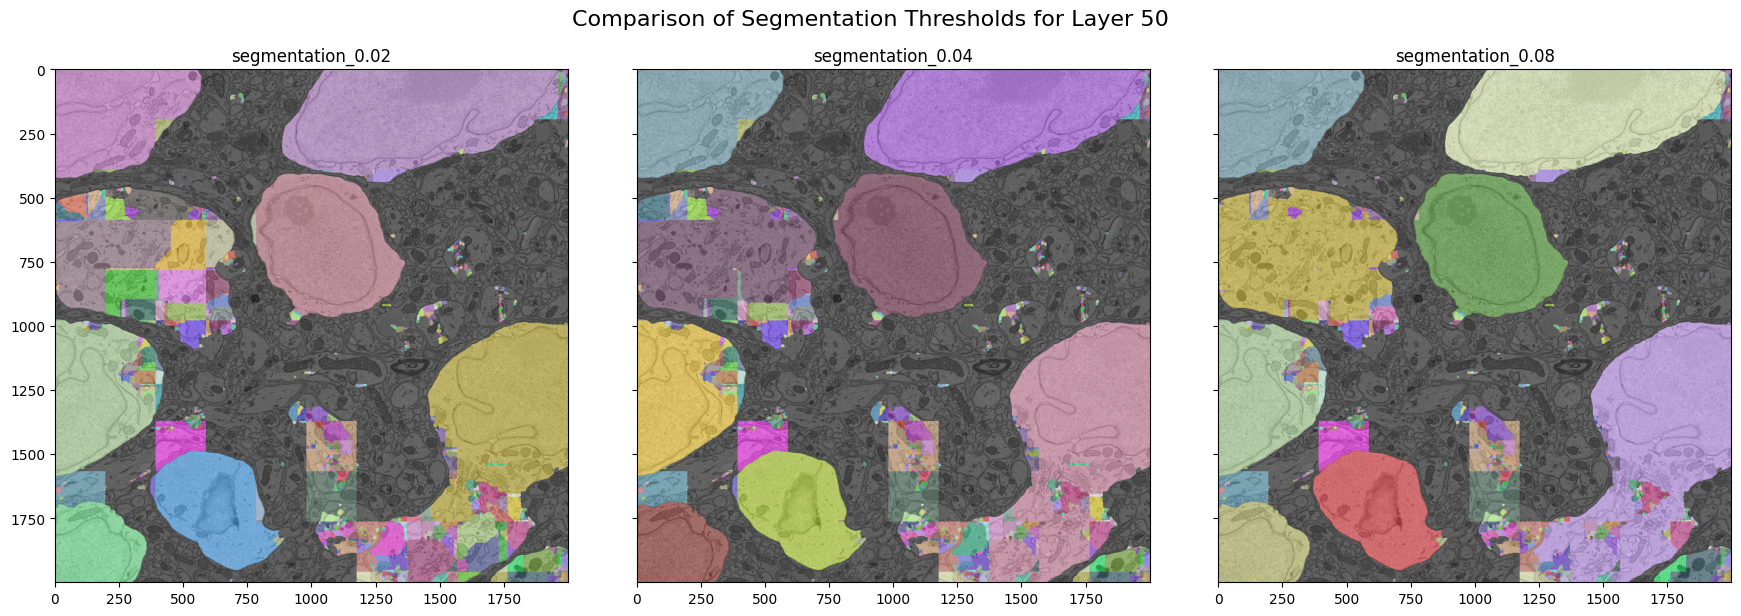

In [26]:
layer = 50
segmentation1 = 'segmentation_0.02'
segmentation2 = 'segmentation_0.04'
segmentation3 = 'segmentation_0.08'  
raw_layer = data['raw'][layer,:,:]
segmentation_layer1 = create_lut_optimized(np.squeeze(preds[segmentation1][layer,:,:]))
segmentation_layer2 = create_lut_optimized(np.squeeze(preds[segmentation2][layer,:,:]))
segmentation_layer3 = create_lut_optimized(np.squeeze(preds[segmentation3][layer,:,:]))

fig, axes = plt.subplots(
            1,
            3,
            figsize=(18, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

# view segmentations
axes[0][0].imshow(raw_layer, cmap='gray')
axes[0][0].imshow(segmentation_layer1, alpha=0.5)
axes[0][0].set_title(segmentation1)


axes[0][1].imshow(raw_layer, cmap='gray')
axes[0][1].imshow(segmentation_layer2, alpha=0.5)
axes[0][1].set_title(segmentation2)

axes[0][2].imshow(raw_layer, cmap='gray')
axes[0][2].imshow(segmentation_layer3, alpha=0.5)
axes[0][2].set_title(segmentation3)

# Set an overall title for the figure
fig.suptitle(f'Comparison of Segmentation Thresholds for Layer {layer}', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust top spacing to fit the suptitle
plt.show()



create_lut_optimized
Number of unique labels: 778
Processing 777/778 100%
Time elapsed: 0.168s
create_lut_optimized
Number of unique labels: 660
Processing 659/660 100%
Time elapsed: 0.165s
create_lut_optimized
Number of unique labels: 320
Processing 319/320 100%
Time elapsed: 0.153s


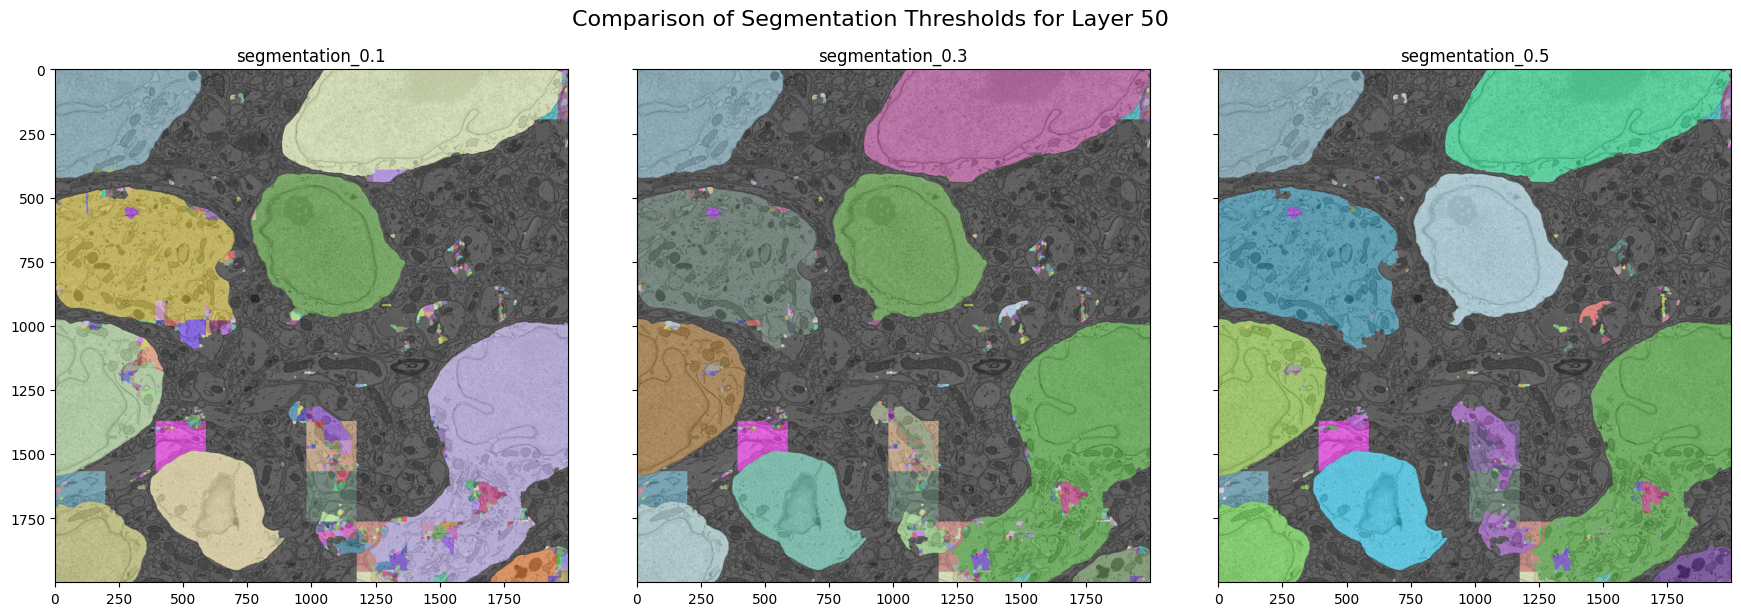

In [27]:
layer = 50
segmentation1 = 'segmentation_0.1'
segmentation2 = 'segmentation_0.3'
segmentation3 = 'segmentation_0.5'  
raw_layer = data['raw'][layer,:,:]
segmentation_layer1 = create_lut_optimized(np.squeeze(preds[segmentation1][layer,:,:]))
segmentation_layer2 = create_lut_optimized(np.squeeze(preds[segmentation2][layer,:,:]))
segmentation_layer3 = create_lut_optimized(np.squeeze(preds[segmentation3][layer,:,:]))

fig, axes = plt.subplots(
            1,
            3,
            figsize=(18, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

# view segmentations
axes[0][0].imshow(raw_layer, cmap='gray')
axes[0][0].imshow(segmentation_layer1, alpha=0.5)
axes[0][0].set_title(segmentation1)


axes[0][1].imshow(raw_layer, cmap='gray')
axes[0][1].imshow(segmentation_layer2, alpha=0.5)
axes[0][1].set_title(segmentation2)

axes[0][2].imshow(raw_layer, cmap='gray')
axes[0][2].imshow(segmentation_layer3, alpha=0.5)
axes[0][2].set_title(segmentation3)

# Set an overall title for the figure
fig.suptitle(f'Comparison of Segmentation Thresholds for Layer {layer}', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust top spacing to fit the suptitle
plt.show()



**Filtering Small Objects**

We will remove objects that span less than 5 layers.

```
screen -S filter
conda activate lsd_new
cd /data/base/3M-APP-SCN/02_train/setup04/prediction

python segmentation_counts.py --input_zarr /data/base/3M-APP-SCN/02_train/setup04/prediction/APP-3M-SCN-SomaGT.zarr --dataset segmentation_0.5 --num_cores 32

python filter_counts.py --input_zarr /data/base/3M-APP-SCN/02_train/setup04/prediction/APP-3M-SCN-SomaGT.zarr \
--input_dataset segmentation_0.5 \
--output_dataset segmentation_0.5_filtered \
--counts_pickle_path /data/base/3M-APP-SCN/02_train/setup04/prediction/combined_counts.pkl \
--threshold 5 \
--num_cores 32

```

In [8]:
preds['segmentation_0.3_filtered'].sh

<zarr.core.Array '/segmentation_0.3_filtered' (200, 2000, 2000) uint64 read-only>

create_lut_optimized
Number of unique labels: 11
Processing 10/11 100%
Time elapsed: 0.162s


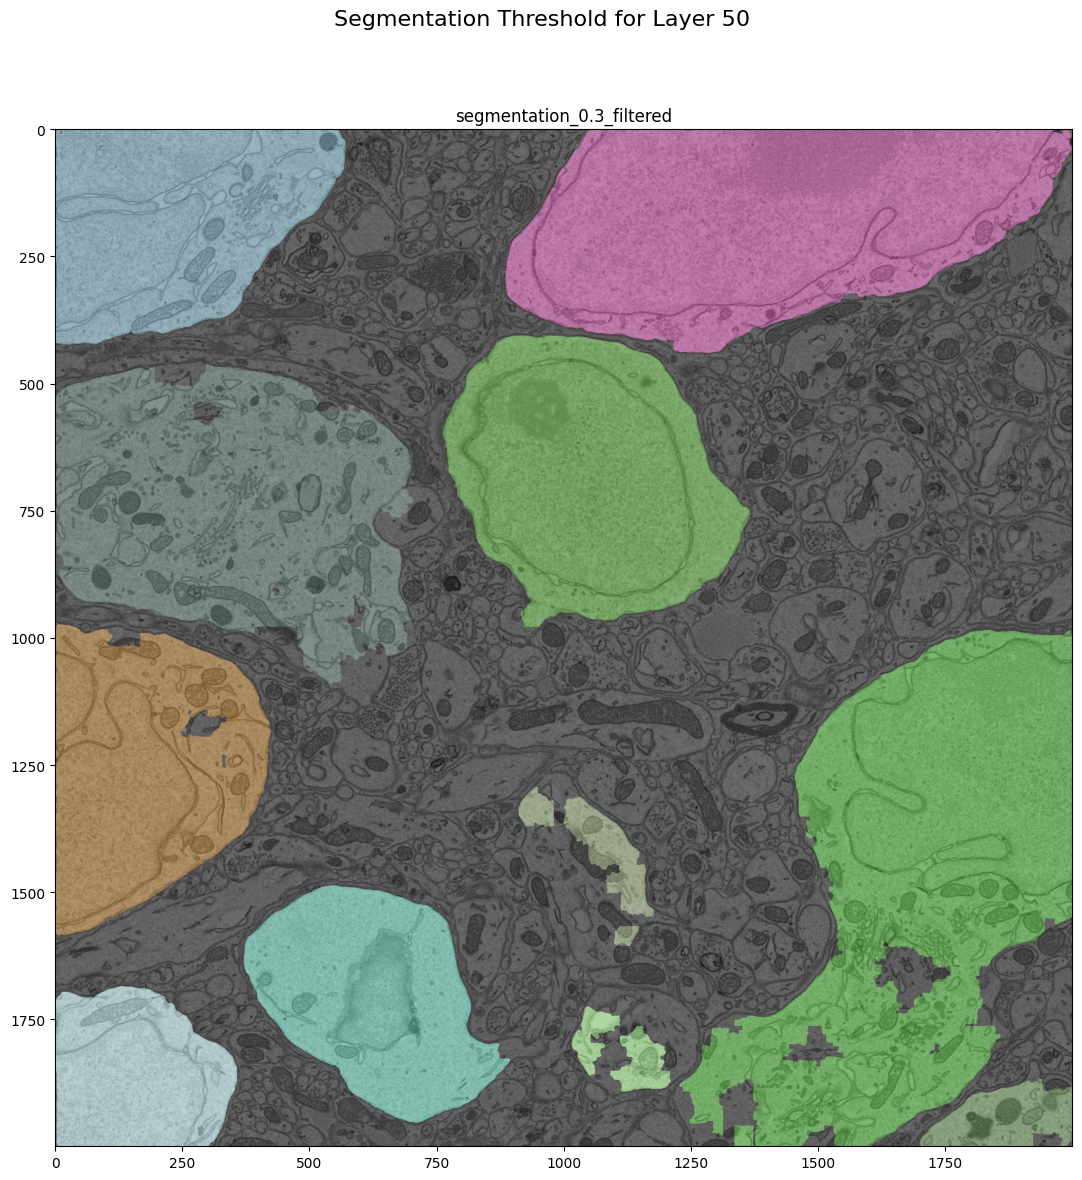

In [9]:
layer = 50
preds = zarr.open('/data/base/3M-APP-SCN/02_train/mtlsd_soma/prediction/CompImBio800M-Soma_filtered.zarr', mode='r')
segmentation1 = 'segmentation_0.3_filtered'

raw_layer = data['raw'][layer,:,:]
segmentation_layer1 = create_lut_optimized(np.squeeze(preds[segmentation1][layer,:,:]))

fig, axes = plt.subplots(
            1,
            1,
            figsize=(12, 12),
            sharex=True,
            sharey=True,
            squeeze=False)

# view segmentations
axes[0][0].imshow(raw_layer, cmap='gray')
axes[0][0].imshow(segmentation_layer1, alpha=0.5)
axes[0][0].set_title(segmentation1)


# Set an overall title for the figure
fig.suptitle(f'Segmentation Threshold for Layer {layer}', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust top spacing to fit the suptitle
plt.show()



create_lut_optimized
Number of unique labels: 2239
Processing 2238/2239 100%
Time elapsed: 0.598s


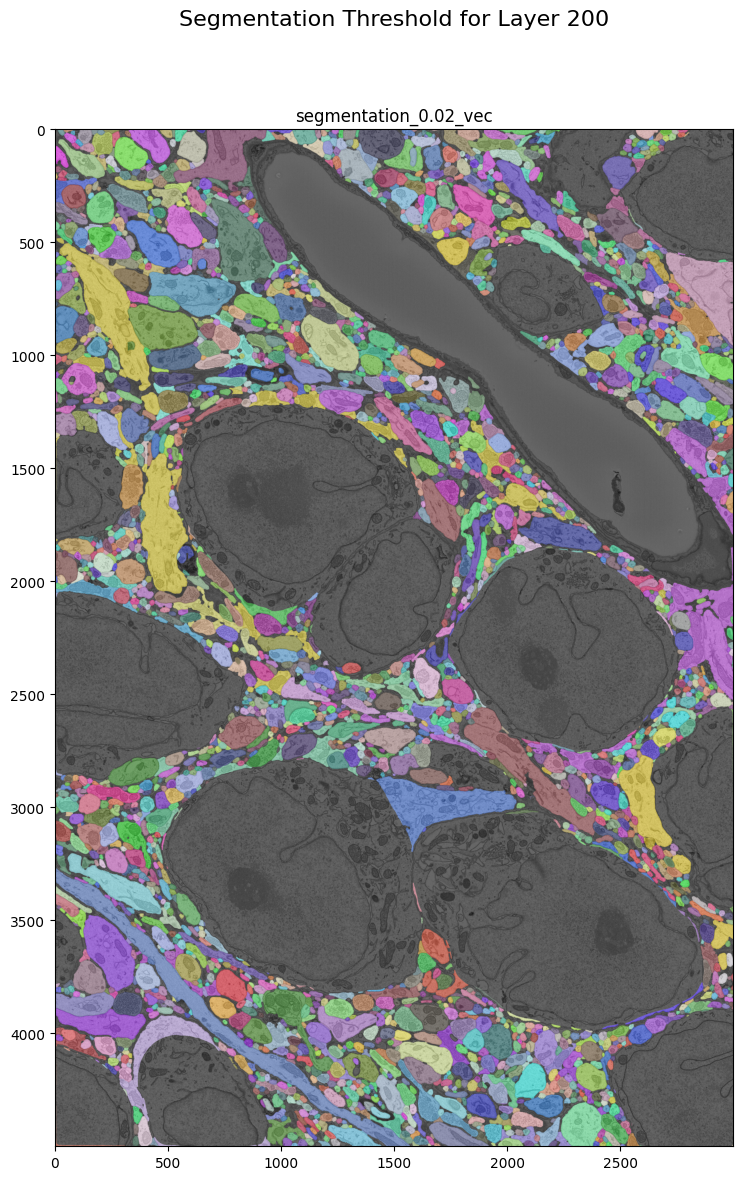

In [54]:
layer = 200
preds = zarr.open('/data/base/3M-APP-SCN/02_train/setup04/prediction/APP-3M-SCN-SomaGT_filtered.zarr', mode='r')
segmentation1 = 'segmentation_0.02_vec'

raw_layer = data['raw'][layer,:,:]
segmentation_layer1 = create_lut_optimized(np.squeeze(preds[segmentation1][layer,:,:]))

fig, axes = plt.subplots(
            1,
            1,
            figsize=(12, 12),
            sharex=True,
            sharey=True,
            squeeze=False)

# view segmentations
axes[0][0].imshow(raw_layer, cmap='gray')
axes[0][0].imshow(segmentation_layer1, alpha=0.5)
axes[0][0].set_title(segmentation1)


# Set an overall title for the figure
fig.suptitle(f'Segmentation Threshold for Layer {layer}', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust top spacing to fit the suptitle
plt.show()



In [45]:
def get_chunk_ranges(shape, chunk_size):
    """
    Calculate the ranges of indices for each chunk.
    """
    ranges = [range(0, s, cs) for s, cs in zip(shape, chunk_size)]
    return np.array(np.meshgrid(*ranges, indexing='ij')).reshape(len(shape), -1).T

# get_chunk_ranges(preds[])
preds = zarr.open('/data/base/3M-APP-SCN/02_train/setup04/prediction/APP-3M-SCN-SomaGT.zarr', mode='r')

get_chunk_ranges(preds['segmentation_0.1'].shape, preds['segmentation_0.1'].chunks).shape

(2576, 3)

**Remap IDs**

This renames the IDs from their much larger segmentation values from the fragment agglomeration process, to their unique values from 1 to the max number of unique IDs. 

```
python remap_ids.py --input_zarr /data/base/3M-APP-SCN/02_train/setup04/prediction/APP-3M-SCN-SomaGT.zarr \
--input_dataset segmentation_0.5_filtered \
--output_zarr /data/base/3M-APP-SCN/02_train/setup04/prediction/APP-3M-SCN-SomaGT_filtered.zarr \
--output_dataset segmentation_0.5 \
--num_cores 32;

```

**Copy Files from LSD to Knossos**

First compress the zarr

```
zip -r APP-3M-SCN-SomaGT_filtered_thresh.zarr.zip APP-3M-SCN-SomaGT_filtered.zarr

SSH into the WebKnossos instance then run the command (update the instance address):

```
rsync -az --info=progress2 -e "ssh -i ~/.ssh/LSD_key.pem" ubuntu@ec2-52-33-11-244.us-west-2.compute.amazonaws.com:/data/base/3M-APP-SCN/02_train/mtlsd_soma/prediction/APP-3M-SCN-SomaGT_filtered_thresh.zarr.zip .
```